In [1]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt

In [2]:
#The Defines
Truck_PATH = 'images/truck.gif'
Truck_NOISE_PATH = 'images/truckNoise.gif'
BORDER_TYPE = cv2.BORDER_CONSTANT
D0 = 10

In [3]:
## Functions

def create_mask(D0, src, mask_type): # This function will be convolving a FILTER_SIZE * FILTER_SIZE filter with the image
    mask = np.zeros_like(src, float)
    if mask_type == "Gaussian":
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                mask[i, j] = (np.exp(-1 * ((i - int(src.shape[0]/2 + 1)) * (i - int(src.shape[0]/2 + 1)) + (j - int(src.shape[1]/2 + 1)) * (j - int(src.shape[1]/2 + 1))) / (2 * D0 * D0))) / (2 * np.pi * D0 * D0)    
    elif mask_type == "Ideal":
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                mask[i, j] = ((i - int(src.shape[0]/2 + 1)) * (i - int(src.shape[0]/2 + 1)) + (j - int(src.shape[1]/2 + 1)) * (j - int(src.shape[1]/2 + 1))) < (D0 * D0)
    return mask

In [4]:
# We are reading the image
Truck_img = np.array(Image.open(Truck_PATH), dtype=float)
Truck_Noise_img = np.array(Image.open(Truck_NOISE_PATH), dtype=float)

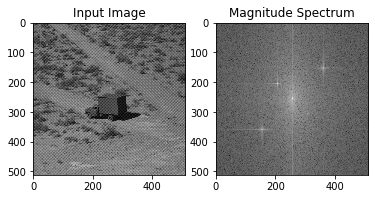

In [5]:
# We calcualte the dft pf the image that we have 
DFT = np.fft.fft2(Truck_img)
DFT = np.fft.fftshift(DFT)

DFT_N = np.fft.fft2(Truck_Noise_img)
DFT_N = np.fft.fftshift(DFT_N)

# We plot the result that we have
plt.subplot(121),plt.imshow(Truck_Noise_img, cmap = 'gray')
plt.title('Input Image')
plt.subplot(122),plt.imshow(20 * np.log(np.abs(DFT_N)), cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.show()


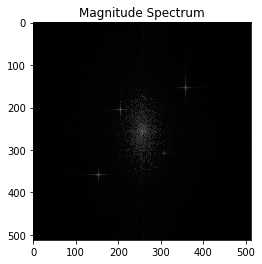

In [6]:

### making the new image
# We also need to determin where we want to git rid of the noises because there are 4 spot in the freq domain
color_filter = np.abs(DFT_N)
CUT_OFF = 10
FRAME_SIZE = 10
Temp = np.copy(color_filter)
Temp[np.log(color_filter) > CUT_OFF] = 5 * np.power(np.log(color_filter[np.log(color_filter) > CUT_OFF]), 4) 
plt.imshow(Temp, cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.show()

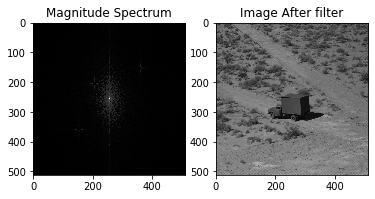

In [7]:
# We also need to determin where we want to git rid of the noises because there are 4 spot in the freq domain
# assume those splots with very low vale
NEW_DFT_N = np.copy(DFT_N)
NEW_DFT_N
NEW_DFT_N[200:211, 200:211] = 0.01#432605.2
NEW_DFT_N[352:363, 148:159] = 0.01#432605.2
NEW_DFT_N[149:159, 353:363] = 0.01#432605.2
NEW_DFT_N[304:314, 304:314] = 0.01#432605.2


color_filter = np.abs(NEW_DFT_N)
CUT_OFF = 10
FRAME_SIZE = 10
Temp = np.copy(color_filter)
# And for the rest of the pixels we will magnify them to see them better
Temp[np.log(color_filter) > CUT_OFF] = 5 * np.power(np.log(color_filter[np.log(color_filter) > CUT_OFF]), 4) 
plt.subplot(121),plt.imshow(Temp, cmap = 'gray')
plt.title('Magnitude Spectrum')
# At the end we will plot the image
im_back = np.fft.ifftshift(NEW_DFT_N)
im_back = (np.abs(np.fft.ifft2(im_back))).round()
plt.subplot(122),plt.imshow(im_back, cmap = 'gray')
plt.title('Image After filter')
plt.show()

In [8]:
# In this part we are going to calculte every parameter that we need like the power of the signals and noise
Noise = Truck_Noise_img - Truck_img
New_Noise = im_back - Truck_img
P_Noise = np.sum(Noise * Noise)
P_New_Noise = np.sum(New_Noise * New_Noise)
P_Signal = np.sum(Truck_img * Truck_img)
P_New_Signal = np.sum(im_back * im_back)
SNR1 = 10 * np.log10(P_Signal/P_Noise)
SNR2 = 10 * np.log10(P_Signal/P_New_Noise)

MAXI = 255
# By knowing the power we can calculte the SNR and PSNR parameters
MSE1 = (P_Noise) / (Noise.shape[0] * Noise.shape[1])
MSE2 = (P_New_Noise) / (New_Noise.shape[0] * New_Noise.shape[1])

PSNR1 = 20 * np.log10(MAXI) - 10 * np.log10(MSE1)
PSNR2 = 20 * np.log10(MAXI) - 10 * np.log10(MSE2)


print("SNR1: ", SNR1)
print("SNR2: ", SNR2)
print("PSNR1: ", PSNR1)
print("PSNR2: ", PSNR2)

SNR1:  17.330300623826137
SNR2:  30.541980560912783
PSNR1:  24.595426932492288
PSNR2:  37.80710686957893
